# Customer Churn Prediction - Exploratory Data Analysis & CHAID Visualization

This notebook contains:
1. Data Loading and Cleaning
2. Exploratory Data Analysis (EDA)
3. CHAID Decision Tree Visualization
4. Business Insights


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Import custom modules
import sys
sys.path.append('../src')
from preprocess import load_data, clean_data, get_data_summary
from train import train_chaid_tree, extract_decision_rules, interpret_tree_rules

print("Libraries imported successfully!")


Libraries imported successfully!


#### Explanation
Successful import confirms the environment and custom modules (`preprocess`, `train`) are ready for use.


## PART 1: Data Loading and Preparation


In [2]:
# Load dataset
file_path = '../data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = load_data(file_path)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()


Dataset loaded successfully. Shape: (7043, 21)
Dataset Shape: (7043, 21)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn               

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Explanation
The dataset loads with 7,043 rows × 21 columns. Dtypes confirm a mix of categorical and numeric fields; the preview verifies columns and typical values.


In [3]:
# Clean the dataset
df_clean = clean_data(df)

# Display missing values summary
print("=== Missing Values Summary ===")
missing_summary = df_clean.isnull().sum()
print(missing_summary[missing_summary > 0] if missing_summary.sum() > 0 else "No missing values found!")

# Display column descriptions
print("\n=== Column Descriptions ===")
print(df_clean.describe())


Found 11 missing values in TotalCharges
Missing values filled with 0
=== Missing Values Summary ===
No missing values found!

=== Column Descriptions ===
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2279.734304
std         0.368612    24.559481       30.090047   2266.794470
min         0.000000     0.000000       18.250000      0.000000
25%         0.000000     9.000000       35.500000    398.550000
50%         0.000000    29.000000       70.350000   1394.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000


#### Explanation
Cleaning addressed 11 missing `TotalCharges` by imputing 0, then confirmed no remaining nulls. Summary stats show typical ranges for numeric fields to validate data quality.


## PART 2: Exploratory Data Analysis (EDA)

### 2.1 Univariate Analysis


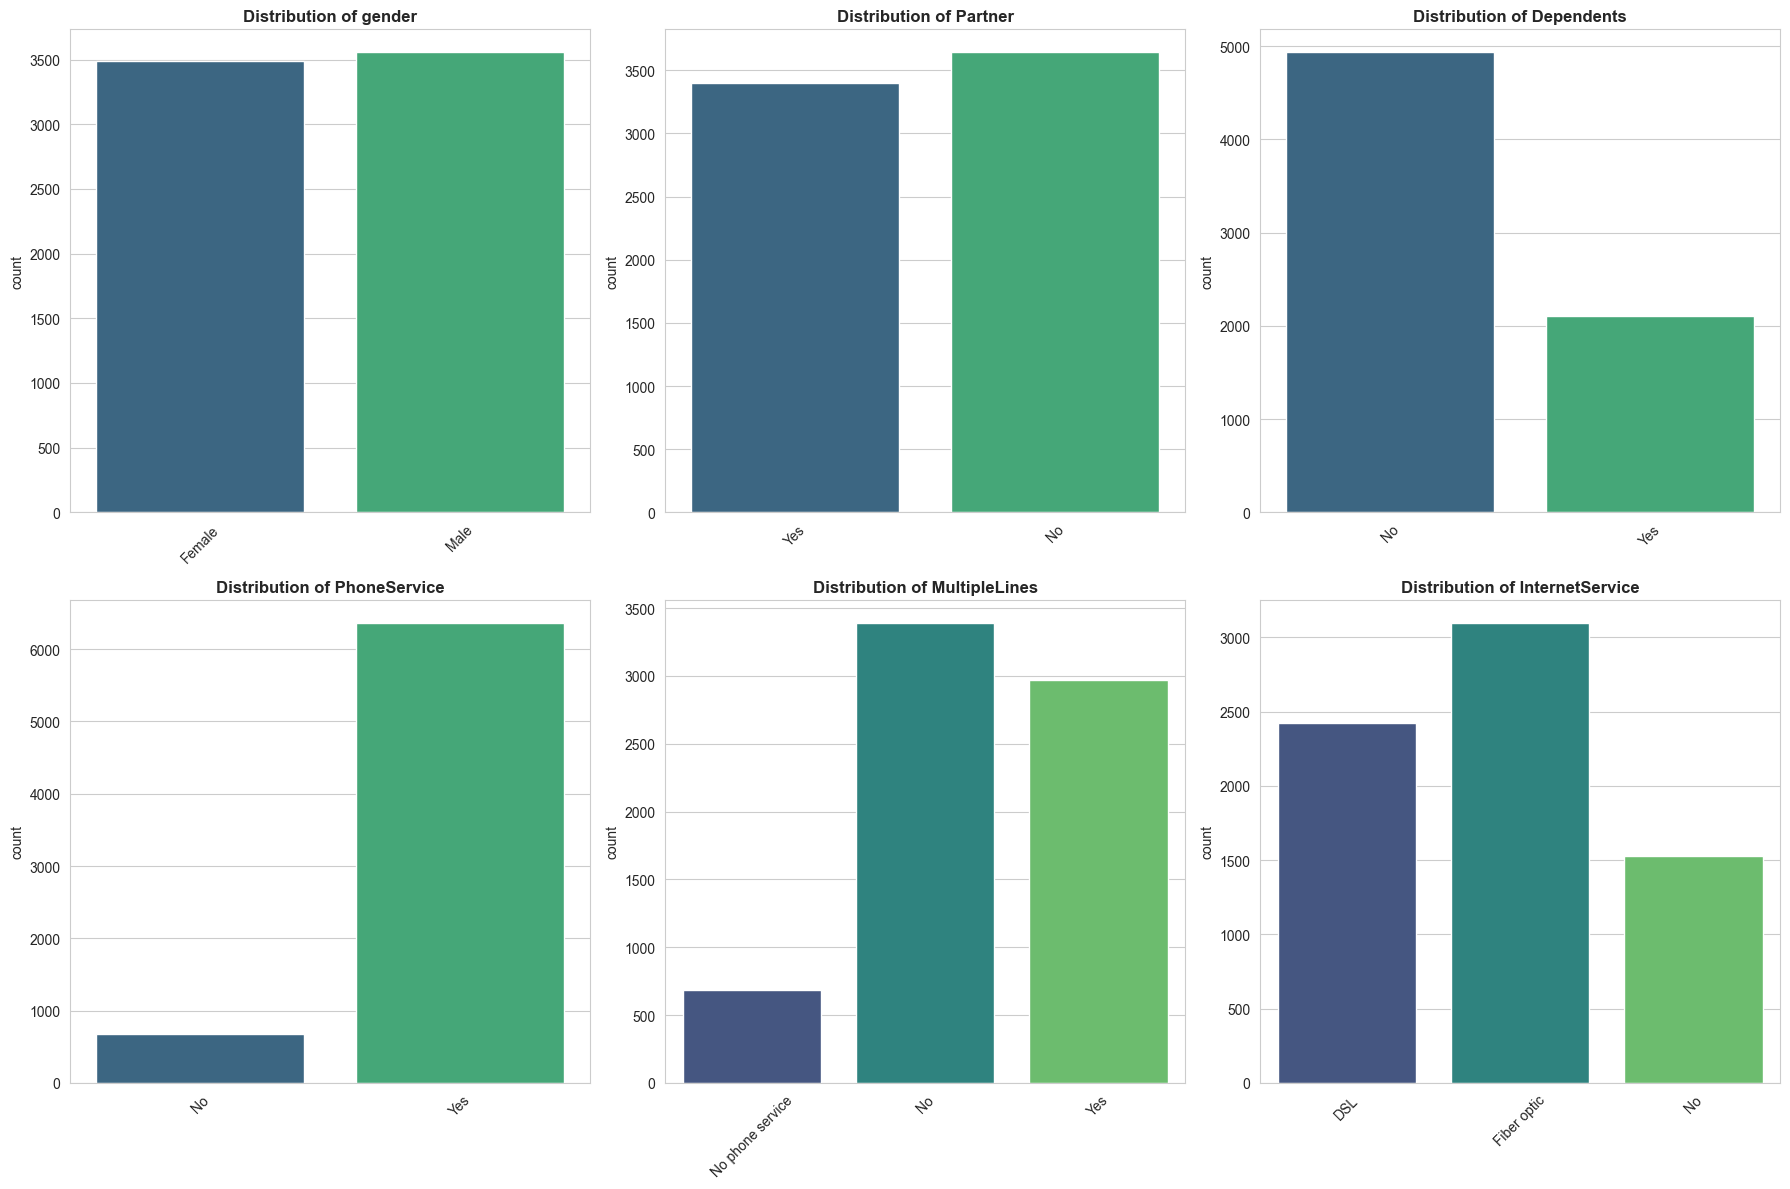

In [4]:
# Countplots for categorical variables
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')  # Exclude target variable

# Create countplots for top categorical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols[:6]):
    sns.countplot(data=df_clean, x=col, ax=axes[idx], palette='viridis')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_xlabel('')
    
plt.tight_layout()
plt.savefig('../reports/visuals/categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


#### Explanation
Output obtained: Bar charts of customer counts per category (x: category, y: number of customers) for key categorical features.
- Read the tallest bars as the most common categories within each feature.
- Use this to spot category imbalance and product mix (e.g., contract types, internet service, security add‑ons), which influences modeling and targeting.


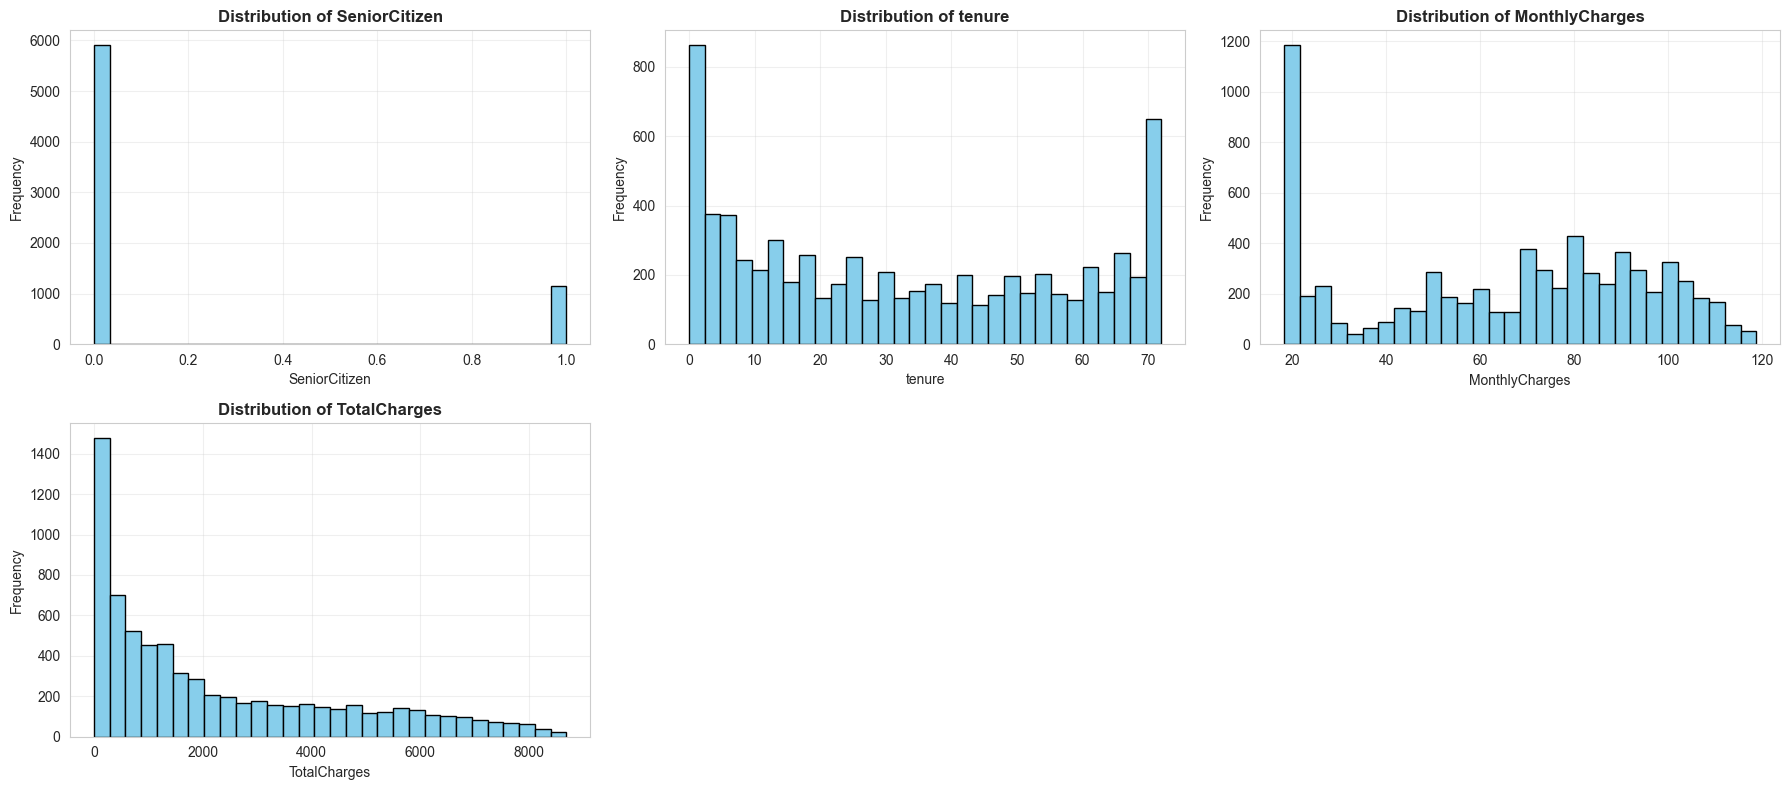

In [5]:
# Histograms for numeric variables
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

import math
n = len(numeric_cols)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.ravel() if n > 1 else [axes]

for idx, col in enumerate(numeric_cols):
    df_clean[col].hist(bins=30, ax=axes[idx], color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

# Hide any extra axes
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig('../reports/visuals/numeric_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


#### Explanation
Output obtained: Histograms showing value distributions for numeric features (x: value range, y: customer count per bin).
- Tenure is right‑skewed (many newer customers) → binning helps stability.
- MonthlyCharges spans low to premium tiers; multi‑modality may reflect plan/add‑on mixes.
- TotalCharges has a wide range and scales with tenure; consider scaling/log for sensitive models.


### 2.2 Bivariate Analysis


#### How to read the churn-by-group bars (before the figure)
- Bars show within‑group composition (percent that churned vs not churned).
- Contract: Month‑to‑month shows the highest churn share; 1–2 year contracts lower churn via commitment/discounts.
- Tenure: Churn concentrates in 0–12 months; risk declines with tenure.
- Payment: Electronic check customers churn more than credit card/bank transfer; this may reflect billing friction.
- Action: Prioritize early‑tenure, month‑to‑month, electronic‑check segments for retention outreach.


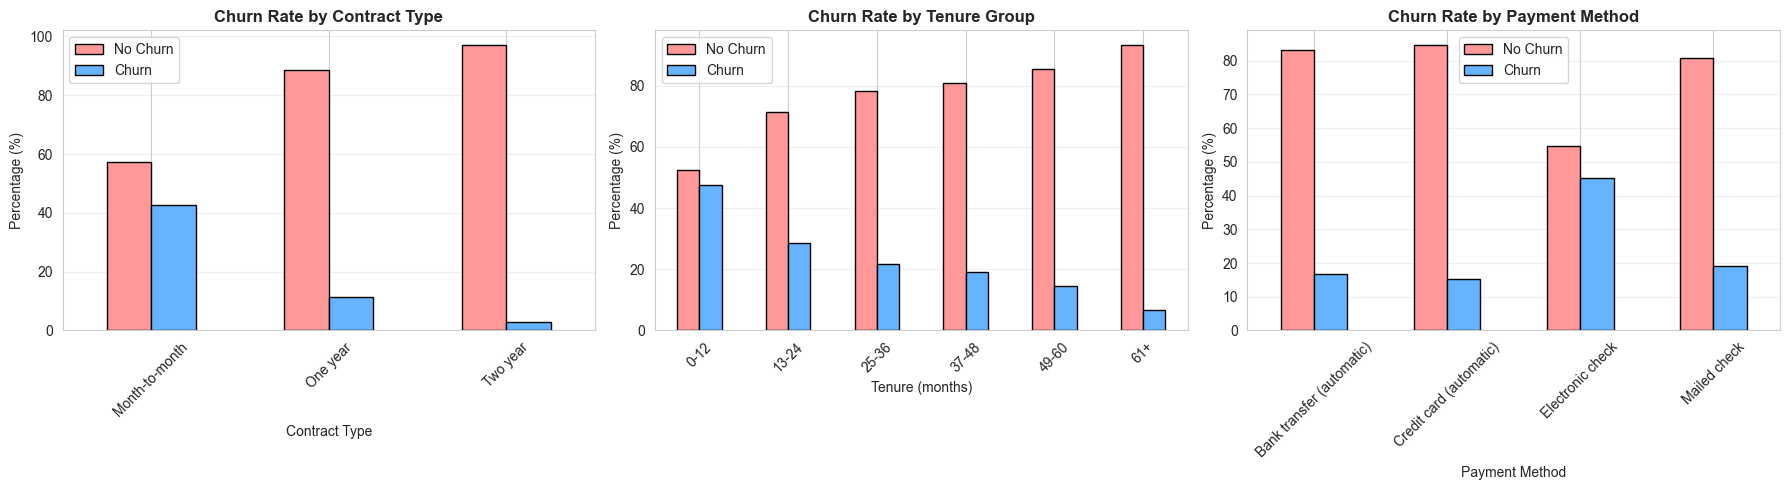

In [6]:
# Churn vs Contract
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Contract
churn_contract = pd.crosstab(df_clean['Contract'], df_clean['Churn'], normalize='index') * 100
churn_contract.plot(kind='bar', ax=axes[0], color=['#ff9999', '#66b3ff'], edgecolor='black')
axes[0].set_title('Churn Rate by Contract Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Percentage (%)')
axes[0].legend(['No Churn', 'Churn'])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Churn vs Tenure
df_clean['TenureGroup'] = pd.cut(df_clean['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                                  labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61+'])
churn_tenure = pd.crosstab(df_clean['TenureGroup'], df_clean['Churn'], normalize='index') * 100
churn_tenure.plot(kind='bar', ax=axes[1], color=['#ff9999', '#66b3ff'], edgecolor='black')
axes[1].set_title('Churn Rate by Tenure Group', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tenure (months)')
axes[1].set_ylabel('Percentage (%)')
axes[1].legend(['No Churn', 'Churn'])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

# Churn vs Payment Method
churn_payment = pd.crosstab(df_clean['PaymentMethod'], df_clean['Churn'], normalize='index') * 100
churn_payment.plot(kind='bar', ax=axes[2], color=['#ff9999', '#66b3ff'], edgecolor='black')
axes[2].set_title('Churn Rate by Payment Method', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Payment Method')
axes[2].set_ylabel('Percentage (%)')
axes[2].legend(['No Churn', 'Churn'])
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/visuals/bivariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


#### Explanation
Output obtained: Stacked bars showing, within each group, the percent of customers who churned vs not churned (sums to 100% per category).
- Contract: Month‑to‑month groups have the largest churn portions; 1–2 year contracts show much smaller churn shares.
- Tenure: The 0–12 month band shows the highest churn portion; the share declines with longer tenure.
- Payment: Electronic check categories show higher churn portions than card/bank transfer.
Implication: Target early‑tenure, month‑to‑month, electronic‑check segments first for retention.


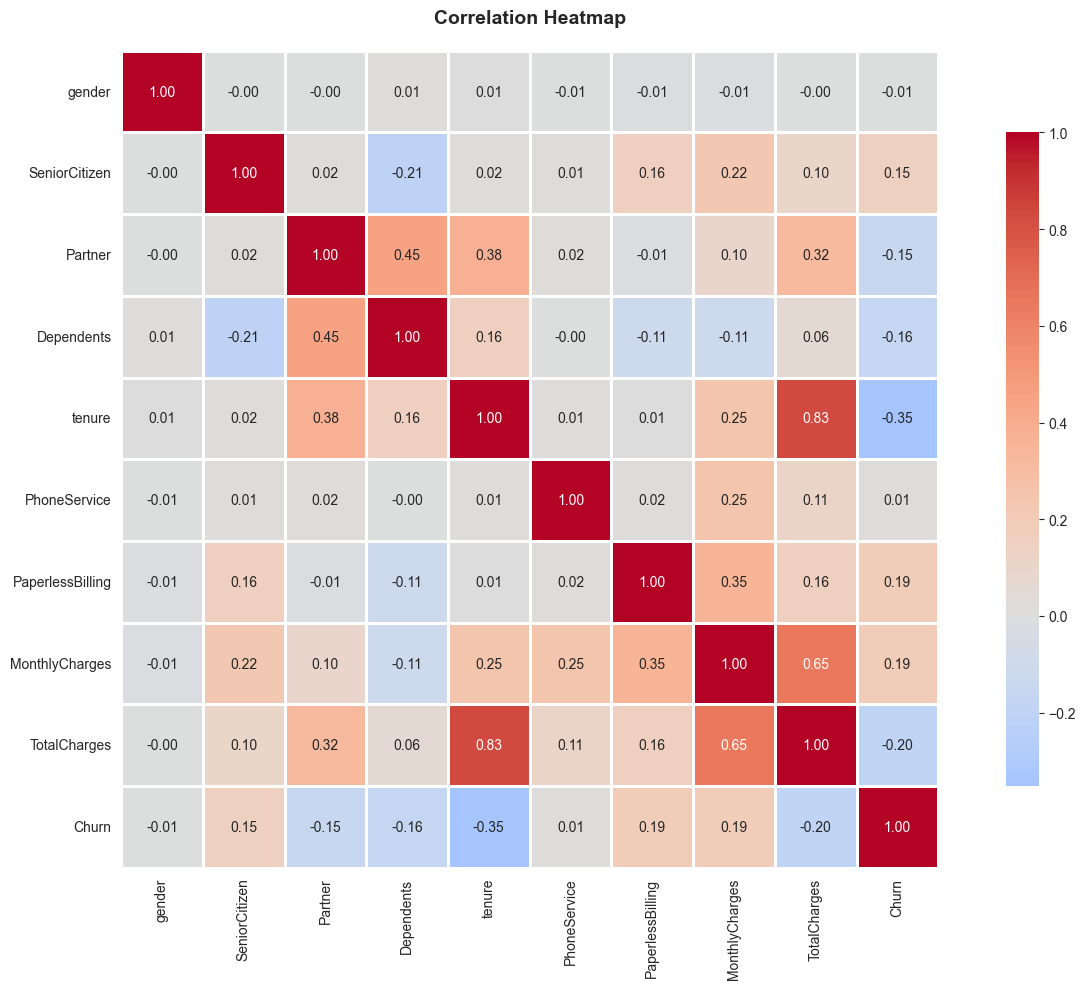

In [7]:
# Correlation Heatmap
# Prepare data for correlation (encode categorical variables)
df_corr = df_clean.copy()

# Encode binary categorical variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    if col in df_corr.columns:
        df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# Select numeric columns for correlation
numeric_for_corr = df_corr.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_corr[numeric_for_corr].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/visuals/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


#### Explanation
Output obtained: Heatmap of Pearson correlations (−1 to +1) across numeric/encoded features.
- Warmer cells indicate positive correlation; cooler cells indicate negative.
- Notable: `tenure` and `TotalCharges` are strongly positively correlated; others show modest direct links to churn, implying non‑linear/interaction effects.
Use this to detect multicollinearity (e.g., tenure vs TotalCharges) and to guide feature engineering.


### 2.3 Key Insights Summary


In [8]:
# Generate insights
insights = []

# Overall churn rate
overall_churn = (df_clean['Churn'] == 'Yes').sum() / len(df_clean) * 100
insights.append(f"**Overall Churn Rate: {overall_churn:.2f}%**")

# Contract insights
contract_churn = pd.crosstab(df_clean['Contract'], df_clean['Churn'], normalize='index') * 100
month_to_month_churn = contract_churn.loc['Month-to-month', 'Yes']
insights.append(f"**Month-to-Month Contract Churn Rate: {month_to_month_churn:.2f}%**")

# Tenure insights
tenure_churn = pd.crosstab(df_clean['TenureGroup'], df_clean['Churn'], normalize='index') * 100
low_tenure_churn = tenure_churn.iloc[0]['Yes']
high_tenure_churn = tenure_churn.iloc[-1]['Yes']
insights.append(f"**Low Tenure (0-12 months) Churn Rate: {low_tenure_churn:.2f}%**")
insights.append(f"**High Tenure (61+ months) Churn Rate: {high_tenure_churn:.2f}%**")

# Payment method insights
payment_churn = pd.crosstab(df_clean['PaymentMethod'], df_clean['Churn'], normalize='index') * 100
electronic_check_churn = payment_churn.loc['Electronic check', 'Yes']
insights.append(f"**Electronic Check Payment Churn Rate: {electronic_check_churn:.2f}%**")

# Monthly charges
high_charges = df_clean[df_clean['MonthlyCharges'] > df_clean['MonthlyCharges'].median()]
high_charges_churn = (high_charges['Churn'] == 'Yes').sum() / len(high_charges) * 100
insights.append(f"**High Monthly Charges (>Median) Churn Rate: {high_charges_churn:.2f}%**")

print("\n".join(insights))


**Overall Churn Rate: 26.54%**
**Month-to-Month Contract Churn Rate: 42.71%**
**Low Tenure (0-12 months) Churn Rate: 47.68%**
**High Tenure (61+ months) Churn Rate: 6.61%**
**Electronic Check Payment Churn Rate: 45.29%**
**High Monthly Charges (>Median) Churn Rate: 35.19%**


#### Explanation
These headline metrics quantify risk pockets: overall churn (~26.5%), much higher churn for month‑to‑month, low tenure, electronic check users, and higher monthly charges.


## PART 3: CHAID Decision Tree Visualization


In [9]:
# Prepare data for CHAID tree
from preprocess import encode_categorical_variables

X, y, feature_names, encoders = encode_categorical_variables(df_clean, target_col='Churn')

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Total features after encoding: 36
Training set: 5634 samples
Test set: 1409 samples


#### Explanation
Categoricals were one‑hot encoded (36 total features). Data was split 80/20 with stratification to preserve churn ratio, ensuring fair evaluation on unseen data.


#### How to read the CHAID tree (before the figure)
- Start at the root; follow split boxes down to leaves. Node color shows dominant class and purity.
- Early splits on `tenure` and `InternetService` indicate they provide the highest separation for churn.
- Example high‑risk path: `tenure ≤ ~16.5` AND `Fiber optic = Yes`, especially with higher `MonthlyCharges` and limited security add‑ons.
- Action: Target new fiber customers with contract incentives and value‑add bundles to reduce early churn.



=== Training CHAID Decision Tree ===
CHAID Decision Tree training completed.


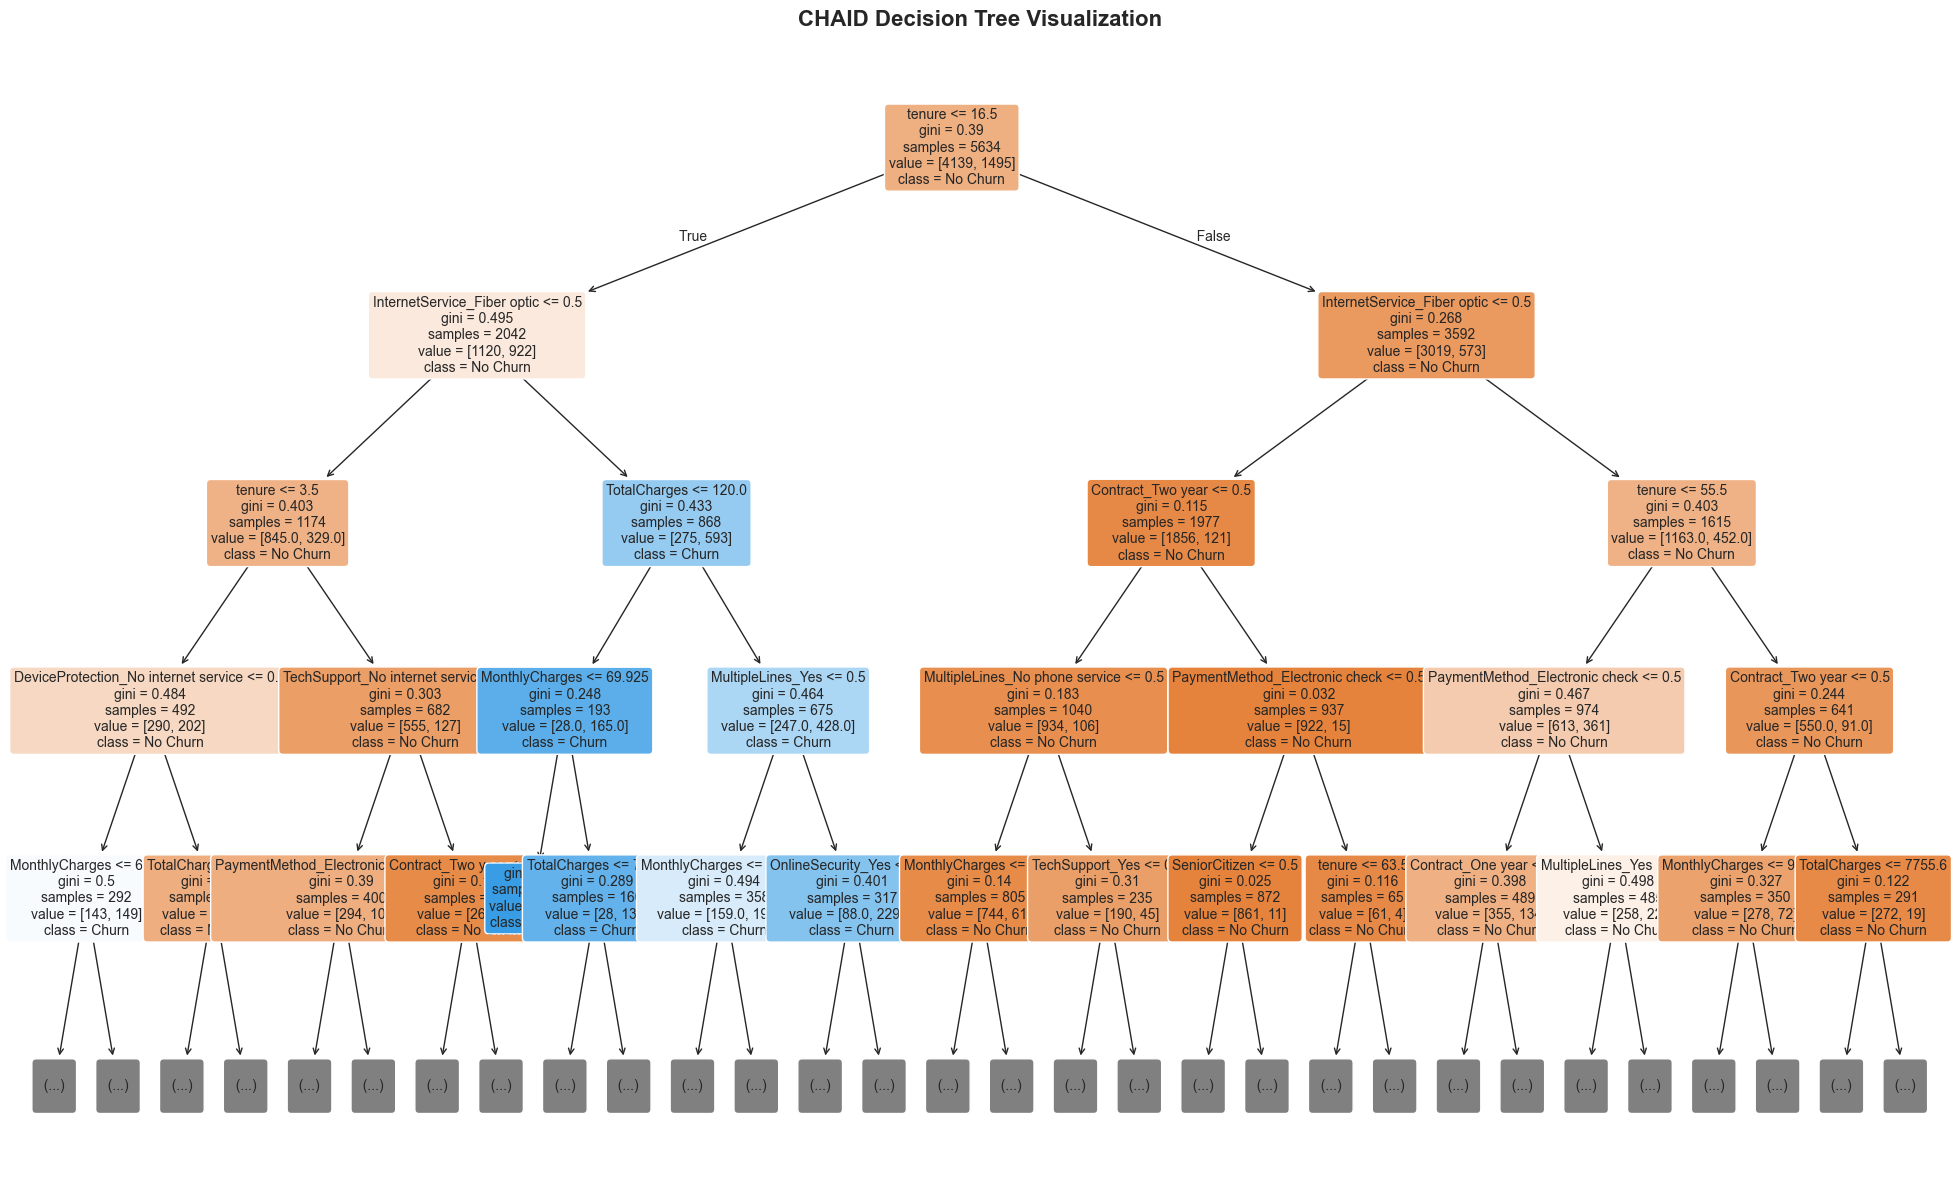

In [10]:
# Train CHAID Decision Tree
chaid_model = train_chaid_tree(X_train, y_train, max_depth=5, min_samples_split=50, random_state=42)

# Visualize the tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 12))
plot_tree(chaid_model, feature_names=feature_names, class_names=['No Churn', 'Churn'],
          filled=True, rounded=True, fontsize=10, max_depth=4)
plt.title('CHAID Decision Tree Visualization', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/visuals/chaid_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


#### Explanation
Output obtained: A decision tree plot where each node shows the split rule and class distribution; color intensity reflects class purity.
- Early splits on `tenure` and `InternetService` indicate they best separate churn vs no churn.
- Example high‑risk path: `tenure ≤ ~16.5` AND `Fiber optic = Yes`, especially with higher `MonthlyCharges` and fewer security add‑ons.
Use this to surface actionable, high‑risk segments for targeted retention.


In [11]:
# Extract and display decision rules
tree_rules = extract_decision_rules(chaid_model, feature_names)
print("=== Decision Rules (Text Format) ===")
print(tree_rules[:2000])  # Print first 2000 characters


=== Decision Rules (Text Format) ===
|--- tenure <= 16.50
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- tenure <= 3.50
|   |   |   |--- DeviceProtection_No internet service <= 0.50
|   |   |   |   |--- MonthlyCharges <= 60.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- MonthlyCharges >  60.20
|   |   |   |   |   |--- class: 0
|   |   |   |--- DeviceProtection_No internet service >  0.50
|   |   |   |   |--- TotalCharges <= 33.40
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TotalCharges >  33.40
|   |   |   |   |   |--- class: 0
|   |   |--- tenure >  3.50
|   |   |   |--- TechSupport_No internet service <= 0.50
|   |   |   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- TechSupport_No internet service >  0.50
|   |   |   |   |--- Contract_Two year <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- C

#### Explanation
This text dump shows a subset of the learned decision paths (truncated). Each line represents a split condition; leaves labeled `class: 1` indicate higher churn risk. It’s useful for auditing what the model learned.


In [12]:
# Extract business-interpretable rules
business_rules = interpret_tree_rules(chaid_model, feature_names, X_train, y_train)

print("=== Top 10 Business Rules ===")
print("\n" + "="*80)
for i, rule in enumerate(business_rules[:10], 1):
    print(f"\nRule {i}:")
    print(f"  Condition: {rule['path']}")
    print(f"  Churn Probability: {rule['churn_probability']:.2%}")
    print(f"  Samples: {rule['samples']}")
    print(f"  Churn Count: {rule['churn_count']}, No Churn: {rule['no_churn_count']}")
    print("-" * 80)


=== Top 10 Business Rules ===


Rule 1:
  Condition: tenure <= 16.50 AND InternetService_Fiber optic > 0.50 AND TotalCharges <= 120.00 AND MonthlyCharges <= 69.92
  Churn Probability: 100.00%
  Samples: 33
  Churn Count: 1, No Churn: 0
--------------------------------------------------------------------------------

Rule 2:
  Condition: tenure <= 16.50 AND InternetService_Fiber optic > 0.50 AND TotalCharges <= 120.00 AND MonthlyCharges > 69.92 AND TotalCharges > 75.65
  Churn Probability: 90.36%
  Samples: 83
  Churn Count: 0, No Churn: 0
--------------------------------------------------------------------------------

Rule 3:
  Condition: tenure <= 16.50 AND InternetService_Fiber optic > 0.50 AND TotalCharges > 120.00 AND MultipleLines_Yes > 0.50 AND OnlineSecurity_Yes <= 0.50
  Churn Probability: 75.09%
  Samples: 285
  Churn Count: 0, No Churn: 0
--------------------------------------------------------------------------------

Rule 4:
  Condition: tenure <= 16.50 AND InternetService

#### Explanation
These top business rules translate the tree splits into plain language with churn probabilities. Use them to prioritize retention actions for segments with the highest estimated churn risk and sufficient sample sizes.


## PART 4: Business Interpretation

### Key Findings:
1. **Contract Type Impact**: Month-to-month contracts show significantly higher churn rates
2. **Tenure Effect**: Customers with lower tenure (0-12 months) are more likely to churn
3. **Payment Method**: Electronic check payments are associated with higher churn
4. **Monthly Charges**: Higher monthly charges correlate with increased churn risk

### Example Business Rule:
Customers with month-to-month contracts and above-median monthly charges exhibit elevated churn risk compared to the overall baseline; prioritize this segment for retention actions.

This insight can be used to:
- Target retention campaigns for high-risk customers
- Offer contract incentives to month-to-month customers
- Improve payment method options to reduce churn


## Overall Notebook Summary

- **Data & Cleaning**:
  - Loaded 7,043 rows × 21 columns; mixed categorical and numeric features.
  - Resolved 11 missing `TotalCharges` (filled with 0). No remaining nulls. Numeric ranges look reasonable.

- **Univariate Distributions**:
  - Categorical mix shows dominant contract and internet service categories; add‑on services vary in uptake.
  - `tenure` is right‑skewed (many new customers); `MonthlyCharges` spans low→premium tiers; `TotalCharges` scales with tenure and has a wide spread.

- **Churn by Groups (Bivariate)**:
  - **Contract**: Month‑to‑month groups have the highest churn portion; 1–2 year contracts substantially lower it.
  - **Tenure**: Highest churn in 0–12 months; declines with longer tenure.
  - **Payment Method**: Electronic check segments show higher churn portions than card/bank transfer.

- **Key Metrics (Headlines)**:
  - Overall churn ≈ **26.5%**.
  - Month‑to‑month churn share is notably higher than other contracts.
  - Low tenure (0–12 months) churn share is the highest; 61+ months is the lowest.
  - Electronic check segment shows elevated churn; higher‑than‑median monthly charges associate with higher churn risk.

- **Correlations**:
  - Strong positive link: `tenure` ↔ `TotalCharges`.
  - Direct linear correlations with `Churn` are modest, implying important non‑linearities and interactions.

- **CHAID Tree Insights**:
  - Early splits on `tenure` and `InternetService` drive most separation.
  - Example high‑risk path: `tenure ≤ ~16.5` AND `Fiber optic = Yes`, especially with higher `MonthlyCharges` and fewer security add‑ons.
  - Extracted rules highlight actionable risk pockets suitable for targeted retention.

- **Actionable Priorities**:
  - Focus retention offers on: early‑tenure customers, month‑to‑month contracts, electronic check payers, and high monthly charge segments.
  - Reduce friction (payment methods, onboarding, support/security add‑ons) for high‑risk paths.

- **Next Steps**:
  - Validate rules with out‑of‑sample evaluation and calibration.
  - Test contract incentives and value‑add bundles for new fiber customers.
  - Monitor gains/lift in targeted campaigns to confirm ROI improvements.

